# Supermarket Sales Data Analysis and Visualization with SQL & Python

#### Connect to the database:
- **SQL Server** Database

- Created in **Azure Data Studio**

- Created using a **Docker Container & ODBC Driver** on MacOS

In [ ]:
import sqlalchemy as sal 

# SQL Server connection details
server = ''
database = ''
username = ''
password = ''
driver = ''  # Path to the ODBC driver on Mac

# Create the connection string without encryption
conn_str = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}&encrypt=no'

# Create SQLAlchemy engine
engine = sal.create_engine(conn_str)

# Connect to the database
conn = engine.connect()

# Show the successful connection
print(conn)

#### Query the Database, Add the Data to DataFrames and Visualize the Results

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### **Calculate Monthly Sales Growth Rate for Q1 2019**

In [4]:
# Define a query to calculate total monthly sales and sales growth rate
sales_growth_query = """ 
    WITH sales_by_month AS(
        SELECT month,
            SUM(cogs) AS total_monthly_sales
        FROM df_sales
        GROUP BY month
    )

    SELECT month,
        total_monthly_sales,
            CAST(
                COALESCE(
                        (total_monthly_sales - LAG(total_monthly_sales) OVER(ORDER BY month)) / LAG(total_monthly_sales) OVER(ORDER BY month) * 100 
                , 0) 
            AS INT) AS sales_growth_rate_perc
    FROM sales_by_month
    ORDER BY month
"""

# Execute the query and store the result in a df
df_sales_growth_rate_q1 = pd.read_sql(sales_growth_query,engine)
df_sales_growth_rate_q1



,month,total_monthly_sales,sales_growth_rate_perc
0,1,110754.16,0
1,2,92589.88,-16
2,3,104243.34,12


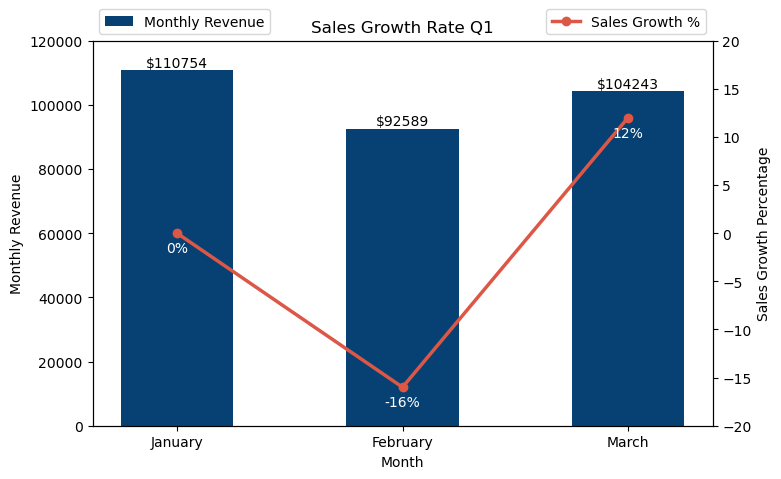

In [155]:
# Bar & Line Plot for the Total Sales and Sales Growth Rate for each month in Q1
fig, ax1 = plt.subplots(figsize=(8, 5))

# Bar plot for the monthly sales
ax1.bar(df_sales_growth_rate_q1['month'], df_sales_growth_rate_q1['total_monthly_sales'], color='#074173', width=0.5)

# Add bar labels
for i in range(len(df_sales_growth_rate_q1)):
    month = df_sales_growth_rate_q1['month'][i]
    monthly_sales = df_sales_growth_rate_q1['total_monthly_sales'][i]
    ax1.text(month, monthly_sales + 1000, f'${int(monthly_sales)}', ha='center', color='black')

# Create second axis in the figure
ax2 = ax1.twinx()

# Line plot for the sales growth percentage
ax2.plot(df_sales_growth_rate_q1['month'], df_sales_growth_rate_q1['sales_growth_rate_perc'], marker='o', color='#DD5746', linewidth=2.5)

# Add labels on the line markers 
for i in range(len(df_sales_growth_rate_q1)):
    month = df_sales_growth_rate_q1['month'][i]
    growth_rate = df_sales_growth_rate_q1['sales_growth_rate_perc'][i]
    ax2.text(month, growth_rate - 2, f'{growth_rate}%', ha='center', color='white')

# Set custom labels for the x-axis
custom_labels = ['January', 'February', 'March']

# Set titles, labels, and legends
ax1.set_title('Sales Growth Rate Q1')
ax1.set_ylabel('Monthly Revenue')
ax1.set_xlabel('Month')
ax1.set_xticks(df_sales_growth_rate_q1['month'])  # Set x-ticks to month numbers
ax1.set_xticklabels(custom_labels, rotation=0)  # Set custom x-tick labels - Jan to March
ax1.set_yticks(range(0, 121000, 20000))
ax2.set_ylabel('Sales Growth Percentage')
ax2.set_yticks(range(-20, 21, 5))
ax1.legend(['Monthly Revenue'], loc='upper left', bbox_to_anchor=(0, 1.1))
ax2.legend(['Sales Growth %'], loc='upper right', bbox_to_anchor=(1, 1.1))

plt.show()


#### *Key Insights*:
- January: Best-performing month with the highest revenue of $110k.

- February: Significant drop with a -16% growth rate and the lowest revenue of $92k, needing attention.

- March: Growth rate recovers to 12%, but revenue still below January's level.

#### *Actionable Steps*:
- Analyze February’s Decline: Investigate the factors contributing to the poor performance in February

- Sustain and Boost Revenue Growth: Develop and implement strategies to maintain the positive growth trend seen in March

###  **Calculate Customer Satisfaction Score(CSAT) for Q1**

In [5]:
# Define a query to calculate the CSAT for Q1
csat_query = """
    SELECT branch_city, csat_by_branch, csat_q1_2019
    FROM (
    SELECT
        branch_city,
            ROUND(
                SUM(CASE WHEN rating >= 6 THEN 1 ELSE 0 END) OVER(PARTITION BY branch_city) / CAST(COUNT(rating) OVER(PARTITION BY branch_city) AS FLOAT)  * 100
            , 0) AS csat_by_branch,
            ROUND(
                SUM(CASE WHEN rating >= 6 THEN 1 ELSE 0 END) OVER() / CAST(COUNT(rating) OVER() AS FLOAT)  * 100
            , 0) AS csat_q1_2019,
        ROW_NUMBER() OVER(PARTITION BY branch_city ORDER BY branch_city) AS rank
        FROM df_sales    
    ) csat
    WHERE rank = 1
"""

# Execute the query and store the result in a df
df_csat = pd.read_sql(csat_query, engine)
df_csat

,branch_city,csat_by_branch,csat_q1_2019
0,A-Yangon,69.0,69.0
1,B-Mandalay,66.0,69.0
2,C-Naypyitaw,70.0,69.0


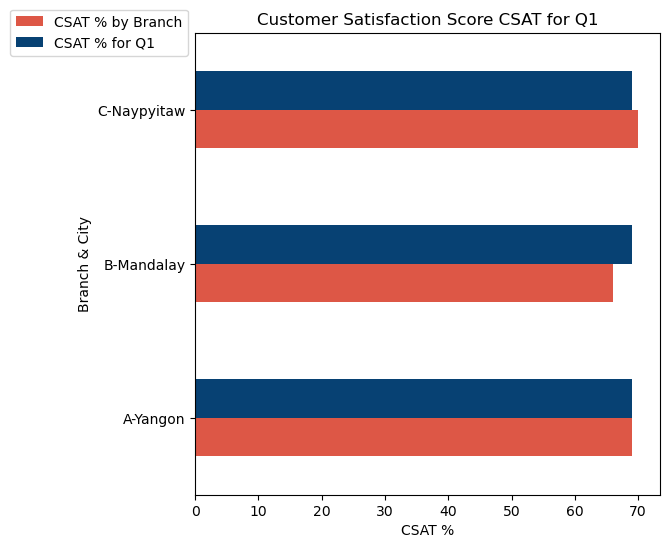

In [115]:
# Side-by-Side Horizontal Bar Plot for the CSAT Score
fig, ax = plt.subplots()

df_csat.plot(kind='barh', x='branch_city', legend=True,
             title='Customer Satisfaction Score CSAT for Q1', figsize= (6,6), color=['#DD5746','#074173'], ax=ax)

# Set titles, labels, and legends
ax.set_ylabel('Branch & City')
ax.set_xlabel('CSAT %')
ax.legend(labels=["CSAT % by Branch", 'CSAT % for Q1'], bbox_to_anchor=(0,1.065))

plt.show()

#### *Key Insights*:
- The CSAT Score of 69% indicates that a significant majority of customers are satisfied, but there is still room for improvement

- Our goal should be to achieve a CSAT score in the range of 80%-90% to ensure higher customer satisfaction.

- Branch C has the highest CSAT score at 70%, while Branch B has the lowest score at 66%.

#### *Actionable Steps*:
- Develop Customer Satisfaction Programs: Introduce more product discounts, coupons, and loyalty programs where customers can collect points for discounts on future purchases.

- Optimize Store Layout: Rearrange product placement to ensure easier access to popular items, making the shopping experience more convenient for customers.

- Improve Customer Support: Invest in training staff to provide better customer service

### **Product Lines' Revenue and Best Performing Month in Q1**

In [125]:
# Define a query to calculate the highest sales and profit for each product line

pl_best_month_query = """
    WITH product_line_totals AS
        (
            SELECT
                product_line,
                month,
                SUM(cogs) AS total_sales,
                SUM(gross_profit) AS total_profit,
                SUM(quantity) AS total_quantity,
                DENSE_RANK() OVER(PARTITION BY product_line ORDER BY SUM(cogs) DESC) AS rank
            FROM df_sales
            GROUP BY product_line, month
        )

    SELECT
        product_line,
        month, 
        (CASE WHEN month = 1 THEN 'Jan'
              WHEN month = 2 THEN 'Feb'
              ELSE 'Mar' END) AS month_name,
        total_sales,
        total_profit,
        total_quantity
    FROM product_line_totals
    WHERE rank = 1
    ORDER BY total_sales DESC
"""

# Execute the query and store the result in a df
df_pl_best_month = pd.read_sql(pl_best_month_query, engine)

# Concatenate product line with month name for readability
df_pl_best_month['line_month'] = df_pl_best_month['product_line'].str.cat(df_pl_best_month['month_name'], sep=' - ') 

# Format sales values as integers with dollar signs
df_pl_best_month['sales_dollars'] = df_pl_best_month['total_sales'].apply(lambda x: '$ ' + np.round(int(x), 0).astype(str))

df_pl_best_month

,product_line,month,month_name,total_sales,total_profit,total_quantity,line_month,sales_dollars
0,Sports and travel,1,Jan,20635.26,1031.78,375,Sports and travel - Jan,$ 20635
1,Home and lifestyle,3,Mar,19935.99,996.79,364,Home and lifestyle - Mar,$ 19935
2,Food and beverages,2,Feb,19047.96,952.39,349,Food and beverages - Feb,$ 19047
3,Fashion accessories,1,Jan,18423.92,921.20,336,Fashion accessories - Jan,$ 18423
4,Electronic accessories,1,Jan,17934.56,896.73,333,Electronic accessories - Jan,$ 17934
5,Health and beauty,3,Mar,17341.25,867.10,334,Health and beauty - Mar,$ 17341


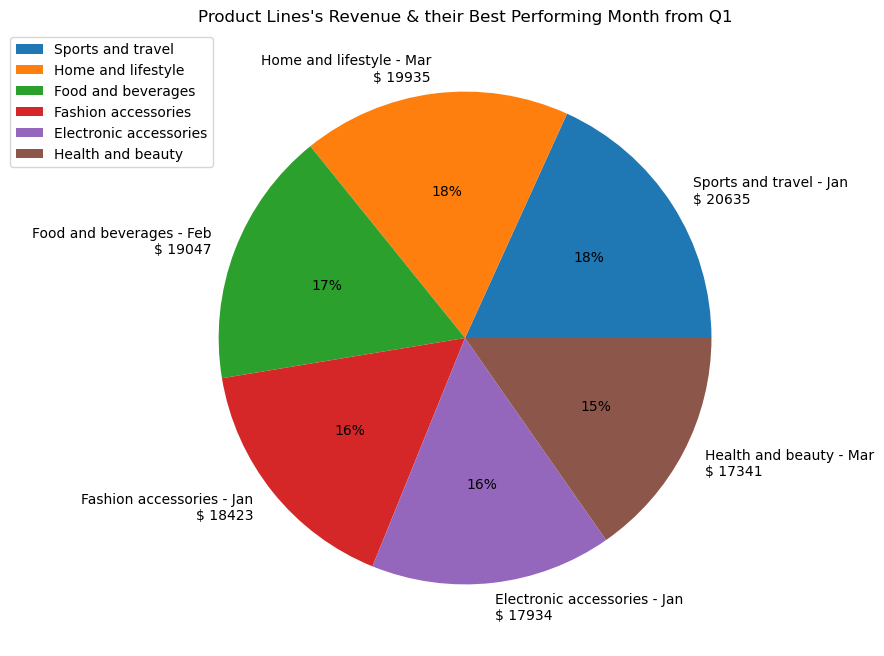

In [126]:
# Pie Chart for the revenue and best month for each product line
fig, ax1 = plt.subplots(figsize=(10,8))

ax1.pie(df_pl_best_month['total_sales'], labels=df_pl_best_month['line_month'].str.cat(df_pl_best_month['sales_dollars'], sep='\n'), autopct='%.0f%%')

# Set title, labels and legend
ax1.legend(labels=df_pl_best_month['product_line'], loc='upper left',  bbox_to_anchor=(-0.25,1))
ax1.set_title("Product Lines' Revenue and Best Performing Month in Q1")

plt.show()

#### *Key Insights*:
* 'Sports and Travel' and 'Home and Lifestyle' lines have the largest market shares at 18%.

* The revenue distribution is fairly balanced, ranging from 17k to 20k monthly.

* January is the best-performing month for most product lines.

* 'Health and Beauty' has the lowest market share and revenue among all product lines - 15%.

* Given the strong correlation between quantity, profit, and sales, increasing inventory for top-performing lines could lead to higher sales and profit.

#### *Actionable Steps*:
- Stock up on merchandise in December to maximize sales in January.

- Expand and diversify the 'Health and Beauty' product line to drive revenue growth.

- Maintain balanced distribution of goods across lines but focus more on 'Sports and Travel' and 'Home and Lifestyle' to potentially increase revenue and profit.

In [123]:
# Order the df by profit and quantity(ascending) 
df_pl_best_month_sorted = df_pl_best_month.sort_values(['total_profit','total_quantity'])
df_pl_best_month_sorted

,product_line,month,month_name,total_sales,total_profit,total_quantity,line_month,profit_dollars
5,Health and beauty,3,Mar,17341.25,867.10,334,Health and beauty - Mar,$ 17341
4,Electronic accessories,1,Jan,17934.56,896.73,333,Electronic accessories - Jan,$ 17934
3,Fashion accessories,1,Jan,18423.92,921.20,336,Fashion accessories - Jan,$ 18423
2,Food and beverages,2,Feb,19047.96,952.39,349,Food and beverages - Feb,$ 19047
1,Home and lifestyle,3,Mar,19935.99,996.79,364,Home and lifestyle - Mar,$ 19935
0,Sports and travel,1,Jan,20635.26,1031.78,375,Sports and travel - Jan,$ 20635


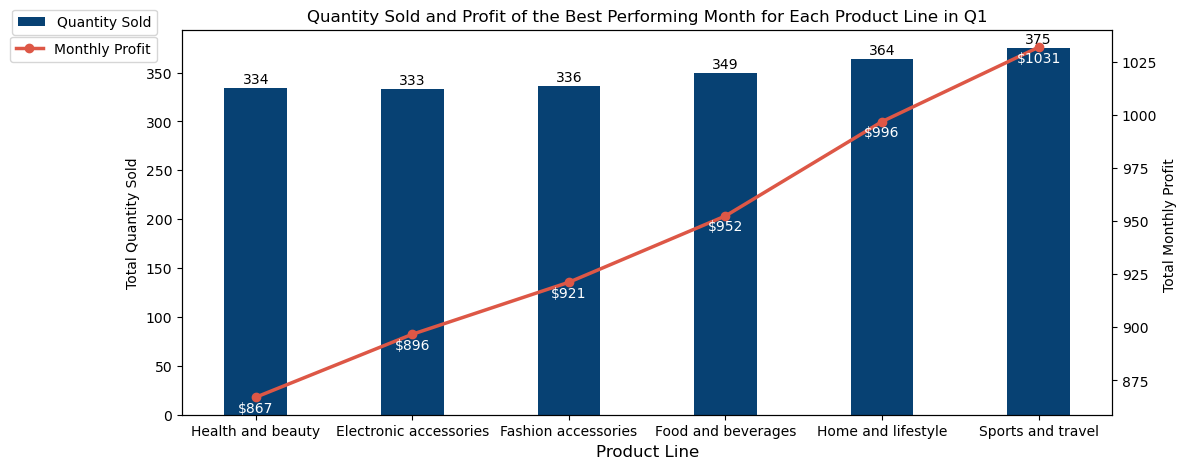

In [127]:
#Quantity Sold and Profit of the Best Performing Month for Each Product Line in Q1
fig, ax1 = plt.subplots(figsize=(12,5))

# Bar plot for the total qty sold
ax1.bar(df_pl_best_month_sorted['product_line'], df_pl_best_month_sorted['total_quantity'], color='#074173', width=0.4)

# Add text annotations
for i in range(len(df_pl_best_month_sorted)):
    line = df_pl_best_month_sorted['product_line'][i]
    qty = df_pl_best_month_sorted['total_quantity'][i]
    ax1.text(line, qty + 5, qty, ha="center")

# Create second axis in the figure
ax2 = ax1.twinx()

# Line plot for the total profit
ax2.plot(df_pl_best_month_sorted['product_line'], df_pl_best_month_sorted['total_profit'], marker='o', color='#DD5746', linewidth=2.5)

# Add text annotations
for i in range(len(df_pl_best_month_sorted)):
    line = df_pl_best_month_sorted['product_line'][i]
    profit = df_pl_best_month_sorted['total_profit'][i]
    ax2.text(line, profit - 7, f'${int(profit)}', ha="center", color='white')

# Set titles, labels and legends
ax1.set_title('Quantity Sold and Profit of the Best Performing Month for Each Product Line in Q1')
ax1.set_ylabel('Total Quantity Sold')
ax1.set_xlabel('Product Line', fontsize=12)
ax2.set_ylabel('Total Monthly Profit ')
ax1.legend(['Quantity Sold'], loc='upper right', bbox_to_anchor=(-0.02,1.07))
ax2.legend(['Monthly Profit'], loc='upper right', bbox_to_anchor=(-0.02,1))

plt.show()

### **Hourly Analysis of Customer Purchases 10am - 8pm**

In [3]:
#At which hours of the day people purchase the most?
most_frequent_hours_query = """
    WITH totals_by_hour AS(
    SELECT hour_24,
        SUM(cogs) AS total_sales,
        SUM(gross_profit) AS total_profit,
        SUM(quantity) AS total_quantity,
        COUNT(hour_24) AS clients_visited
    FROM df_sales
    GROUP BY hour_24
),
gender_purchases_by_hour AS(
    SELECT hour_24,
           gender,
           COUNT(gender) AS total_gen,
           ROW_NUMBER() OVER(PARTITION BY hour_24 ORDER BY COUNT(gender) DESC) AS rn
    FROM df_sales
    GROUP BY hour_24, gender
)

SELECT tbh.hour_24,
       tbh.clients_visited,
       tbh.total_sales,
       tbh.total_profit,
       tbh.total_quantity,
       gp.gender AS gender_buying_more
FROM totals_by_hour tbh 
INNER JOIN gender_purchases_by_hour gp
ON tbh.hour_24 = gp.hour_24
WHERE gp.rn = 1
ORDER BY tbh.total_sales DESC, tbh.total_quantity DESC
"""

# Execute the query and store the result in a df
df_most_frequent_hours = pd.read_sql(most_frequent_hours_query, engine)
df_most_frequent_hours

,hour_24,clients_visited,total_sales,total_profit,total_quantity,gender_buying_more
0,19,113,37809.06,1890.49,649,Male
1,13,103,33069.74,1653.51,585,Female
2,10,101,29925.22,1496.28,525,Female
3,15,102,29694.77,1484.73,530,Male
4,14,83,29360.38,1468.05,495,Male
5,11,90,28930.79,1446.59,513,Female
6,12,89,24824.65,1241.26,501,Female
7,18,93,24790.80,1239.50,475,Male
8,16,77,24025.07,1201.23,420,Male
9,17,74,23281.16,1164.08,415,Female


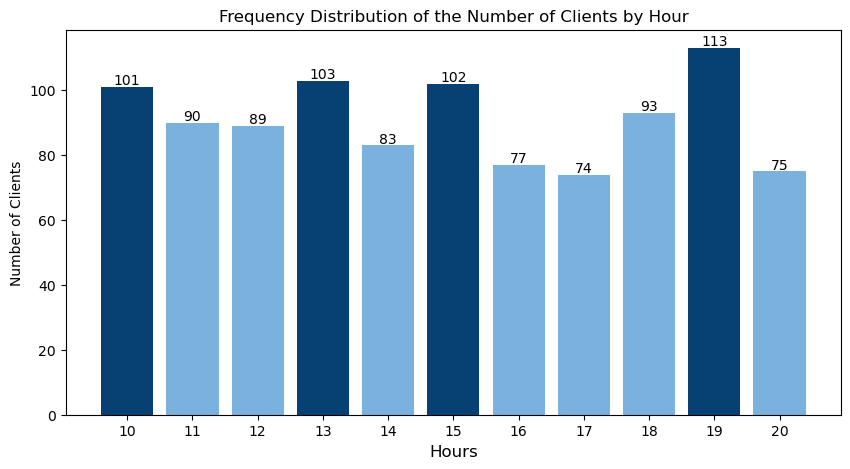

In [5]:
# Frequency Distribution of clients visiting the supermarket in each working hour
fig, ax = plt.subplots(figsize=(10,5))

# Using list comprehansion to select color of the bar
colors = ['#7BB2DD' if value <= 100 else '#074173' for value in df_most_frequent_hours['clients_visited']]

# Histogram for the number of clients for each  hour
ax.bar(df_most_frequent_hours['hour_24'], df_most_frequent_hours['clients_visited'],
       color=colors)

# Add text annotations over the bars
for i in range(len(df_most_frequent_hours)):
    hour = df_most_frequent_hours['hour_24'][i]
    clients = df_most_frequent_hours['clients_visited'][i]
    plt.text(hour, clients + 0.75, clients, ha="center")

# Set titles and labels
ax.set_title('Frequency Distribution of the Number of Clients by Hour')
ax.set_ylabel('Number of Clients')
ax.set_xlabel('Hours', fontsize=12)
# Show all working hours
ax.set_xticks(range(min(df_most_frequent_hours['hour_24']), max(df_most_frequent_hours['hour_24']) + 1))

plt.show()

#### *Key Insights*:

- Women are more likely to shop in the morning or around lunchtime, while men prefer visiting the supermarket later in the day.

- The most frequently visited hours(bringing the most revenue and profit) are:
    - 7 PM - after work hours, before heading home
    - 1 PM - post-lunch hours

- The supermarket experiences the lowest customer traffic at:

    - 5 PM - just before the end of the workday, an inconvenient time for shopping
    - 8 PM - late evening when most people are already home or unlikely to make substantial purchases

- Due to the positive correlation between the number of clients and the sales, profit, and quantity sold, we can assess that the more clients we bring into the supermarket, the higher the revenue and profit growth will be, especially during the most frequently visited hours.

#### *Actionable Steps*:

- Hire additional part-time staff for the 10 AM-2 PM and 3 PM-7 PM shifts to manage high customer volumes.

- Prioritize stocking products frequently bought by women in the morning and by men in the afternoon/evening.

- Utilize off-peak hours to reorganize the store layout and restock inventory or receive goods in the warehouse.

### **Comparative Analysis of Branch Performance**
- Total units sold, revenue, average rating, average profit

- Most frequently used payment method

- Dominant gender

In [8]:
# Define a query to compare the different branches
branch_comparison_query = """
WITH branch_comparison AS(
        SELECT branch_city,
        SUM(quantity) AS total_units_sold,
        SUM(cogs) AS total_revenue,
        SUM(gross_profit) AS total_profit,
        AVG(gross_profit) AS avg_profit,
        AVG(rating) AS avg_rating,
        SUM(CASE WHEN gender = 'Female' THEN 1 ELSE 0 END) AS females,
        SUM(CASE WHEN gender = 'Male' THEN 1 ELSE 0 END) AS males
        FROM df_sales
    GROUP BY branch_city
),
    payment_methods AS(
        SELECT branch_city,
        payment,
        COUNT(payment) as tot_p,
        ROW_NUMBER() OVER(PARTITION BY branch_city ORDER BY COUNT(payment) DESC) AS row_n
        FROM df_sales
        GROUP BY branch_city, payment
)

SELECT bc.branch_city,
       bc.total_units_sold,
       CAST(bc.total_profit AS INT) AS total_profit,
       CAST(bc.total_revenue AS INT) AS total_revenue, 
       CAST(bc.avg_profit AS INT) AS avg_profit_dollars,
       CAST(bc.avg_rating AS INT) AS avg_rating,
       pm.payment,
       bc.females,
       bc.males
FROM branch_comparison bc
INNER JOIN payment_methods pm 
ON bc.branch_city = pm.branch_city
WHERE pm.row_n = 1
ORDER BY 
    total_revenue DESC,
    avg_profit_dollars DESC,  
    total_units_sold DESC
"""

# Execute the query and store the result in a df
df_branch_comparison = pd.read_sql(branch_comparison_query, engine)
# Sort the df by the revenue and avg profit
df_branch_comparison = df_branch_comparison.sort_values(['total_revenue','avg_profit_dollars'])
df_branch_comparison

,branch_city,total_units_sold,total_profit,total_revenue,avg_profit_dollars,avg_rating,payment,females,males
2,B-Mandalay,1820,5057,101140,15,6,Ewallet,162,170
1,A-Yangon,1859,5057,101143,14,7,Ewallet,161,179
0,C-Naypyitaw,1831,5265,105303,16,7,Cash,178,150


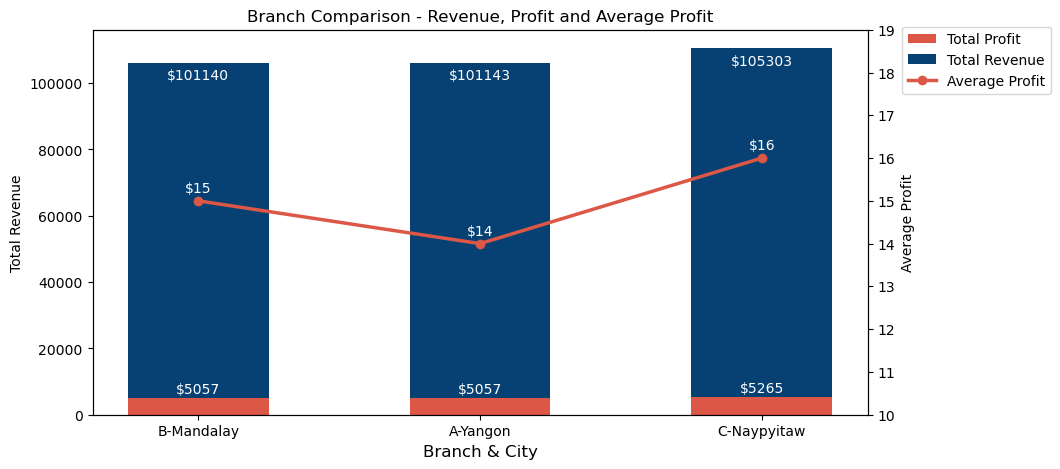

In [167]:
# Stacked Bar plot for the branch comparison
fig, ax1 = plt.subplots(figsize=(10,5))

# Total profit(bottom part of the stacked bar chart)
profit_bars = ax1.bar(df_branch_comparison['branch_city'], df_branch_comparison['total_profit'],color='#DD5746', width=0.5, label='Total Profit')

#Add text annotations over the profit bar
for i in range(len(df_branch_comparison)):
  brch = df_branch_comparison['branch_city'][i]
  profit = df_branch_comparison['total_profit'][i]
  ax1.text(brch, profit + 1500, f'${profit}', ha="center", color='white')

# Total revenue
revenue_bars = ax1.bar(df_branch_comparison['branch_city'], df_branch_comparison['total_revenue'],bottom=df_branch_comparison['total_profit'], color='#074173', width=0.5, label='Total Revenue')

# Add text annotations over the revenue bar
for i in range(len(df_branch_comparison)):
  brch = df_branch_comparison['branch_city'][i]
  revenue = df_branch_comparison['total_revenue'][i]
  ax1.text(brch, revenue, f'${revenue}', ha="center", color='white')

# Create second axis in the figure
ax2 = ax1.twinx()

# Line plot for the avg profit
avg_profit_line = ax2.plot(df_branch_comparison['branch_city'], df_branch_comparison['avg_profit_dollars'], marker='o', color='#DD5746', linewidth=2.5, label='Average Profit')

# Add text annotations over the line markers
for i in range(len(df_branch_comparison)):
  brch = df_branch_comparison['branch_city'][i]
  avg_profit = df_branch_comparison['avg_profit_dollars'][i]
  ax2.text(brch, avg_profit + 0.2, f'${avg_profit}', ha="center", color='white')

# Set titles, labels and legends
ax1.set_title('Branch Comparison - Revenue, Profit and Average Profit')
ax1.set_ylabel('Total Revenue')
ax1.set_xlabel('Branch & City', fontsize=12)
ax2.set_ylabel('Average Profit')
ax2.set_yticks(range(10,20))

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2, loc='upper right', bbox_to_anchor=(1.09, 0.9), ncol=1)

plt.show()

#### *Key Insights*:
- Branch C in Naypyitaw is the top performer with $105k in revenue and 5265 in profit.

- Branches A and B have similar performance levels, though Branch A has the lowest average profit at $14.

- The profit margin across all three branches is relatively low for supermarket goods - 5%.

- Branch B has the fewest clients and the lowest average rating of 6, making it the poorest performer.

#### *Actionable Steps*:
- Branches A and B should focus on acquiring more clients to match Branch C's performance. 

- Increase the purchase of higher-margin products to improve overall margin percentages, especially in Branch A.

- Review and enhance customer experience and inventory management in Branch B to boost customer ratings and sales volume.

In [9]:
# Extract branch and gender distribution data
data_gender_branch = df_branch_comparison[['branch_city', 'females', 'males']]

# Sort by branch name
data_gender_branch.sort_values('branch_city')

,branch_city,females,males
1,A-Yangon,161,179
2,B-Mandalay,162,170
0,C-Naypyitaw,178,150


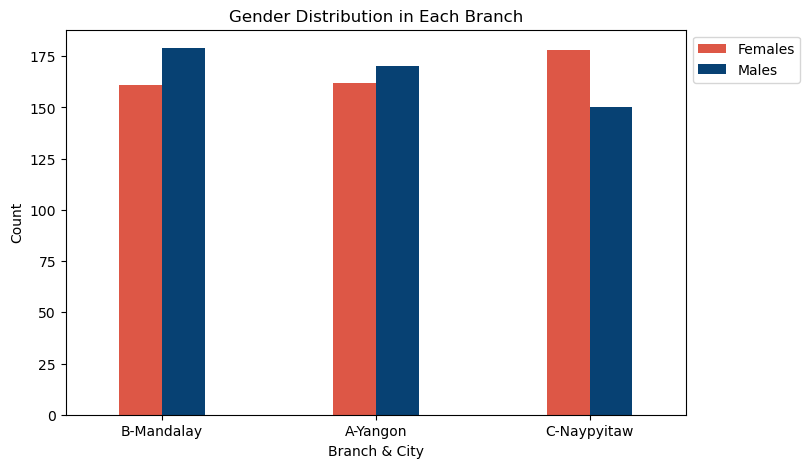

In [10]:
# Side-by-Side Bar plot for the Gender Distribution
fig, ax = plt.subplots(figsize=(8, 5))

# Sorting the DataFrame by 'branch_city' for consistent plotting order
data_gender_branch.sort_values('branch_city').plot(kind='bar', x='branch_city', legend=True,
                                                  title='Gender Distribution in Each Branch',
                                                  color=['#DD5746', '#074173'], width=0.4, ax=ax)

# Set titles, labels, and legends
ax.set_ylabel('Count')
ax.set_xlabel('Branch & City')
ax.set_xticklabels(labels=data_gender_branch['branch_city'], rotation=0)
ax.legend(["Females", 'Males'], bbox_to_anchor=(1, 1))

plt.show()


#### Key Insights:
- Branch C has the highest number of female clients, which may explain why it's the top performer.

- Branches A and B have more male clients than female, even though their gender distributions are fairly balanced.

#### Actionable Steps:
- Branch A should offer discounts and stock more products that appeal to male customers to increase sales.

- Both Branches A and B should expand female-friendly product lines to attract more female customers.

### **Gender-Based Payment Methods Distribution**

In [11]:
# Define a query to compare the different payment methods by gender
payment_methods_by_gender_query = '''
    SELECT *,
        SUM(payment_method_count) OVER(PARTITION BY payment ORDER BY payment, payment_method_count ROWS UNBOUNDED PRECEDING) AS running_total,
        ROUND(
            (SUM(payment_method_count) OVER(ORDER BY payment, payment_method_count ROWS UNBOUNDED PRECEDING)
             / CAST(SUM(payment_method_count) OVER() AS FLOAT)) * 100 
        , 0) AS running_total_percentage
    FROM (
        SELECT payment,
            gender,
            COUNT(*) AS payment_method_count
        FROM df_sales
        GROUP BY payment, gender
    ) AS tot
'''

# Execute the query and store the result in a df
df_payment_methods_by_gender = pd.read_sql(payment_methods_by_gender_query, engine)
df_payment_methods_by_gender


,payment,gender,payment_method_count,running_total,running_total_percentage
0,Cash,Male,166,166,17.0
1,Cash,Female,178,344,34.0
2,Credit card,Male,148,148,49.0
3,Credit card,Female,163,311,66.0
4,Ewallet,Female,160,160,82.0
5,Ewallet,Male,185,345,100.0


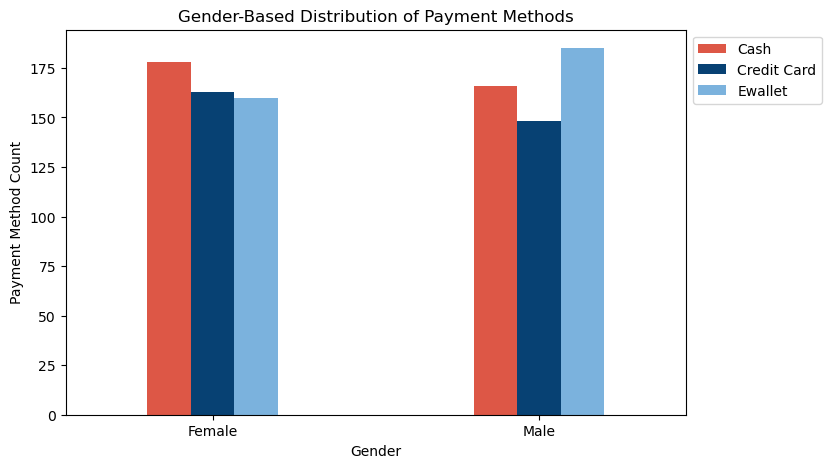

In [12]:
# Pivot Payment Methods into columns with Gender as rows
df_payment_pivot = df_payment_methods_by_gender[['gender', 'payment', 'payment_method_count']].pivot(
                   index='gender', columns='payment', values='payment_method_count').fillna(0)

fig, ax = plt.subplots(figsize= (8,5))

# Plot the Side-by-Side Bar Chart 
df_payment_pivot.plot(kind='bar', legend=True,title='Gender-Based Distribution of Payment Methods',
                      color=['#DD5746','#074173', '#7BB2DD'], linewidth=1, width=0.4, ax=ax)

# Set titles, labels and legends
ax.set_xlabel('Gender')
ax.set_xticklabels(labels=['Female', 'Male'], rotation=0)
ax.set_ylabel('Payment Method Count')
ax.legend(labels=['Cash', 'Credit Card', 'Ewallet'], bbox_to_anchor=(1,1))

plt.show()

#### *Key Insights*:
- Males most frequently used payment method is **Ewallet** and least used is **Credit Card**.

- Females most frequently used payment method is **Cash** and least used is **Ewallet**.

#### *Actionable Steps*:

- **Promote Ewallet usage** by offering discounts or loyalty points for purchases made through Ewallets to encourage usage among females.

- **Encourage Credit Card payments** by providing incentives such as cashback offers or exclusive deals for customers using Credit Cards, especially targeting male customers.

### **Gender-Based Metrics Comparison**
This section analyzes and compares various aggregated metrics between genders, including:

- Total Revenue

- Average Amount Spent

- Quantity Sold

- Average Quantity Bought per Visit

- Average Store Visit Time

- Average Customer Rating

- Number of Members vs. Non-Members

In [13]:
# Define a query to compare different payment metrics by gender
gender_comparison_query = '''
    SELECT gender,
           SUM(cogs) AS total_revenue,
           CAST(ROUND(AVG(cogs), 0) AS INT) AS avg_spent_per_customer,
           SUM(quantity) AS total_qty,
           AVG(quantity) AS avg_qty,
           AVG(hour_24) AS avg_hour_at_store,
           CAST(ROUND(AVG(rating), 0) AS INT) AS avg_rating,
           SUM(CASE WHEN customer_type = 'Member' THEN 1 ELSE 0 END) AS Members,
           SUM(CASE WHEN customer_type = 'Normal' THEN 1 ELSE 0 END) AS NonMembers
    FROM df_sales
    GROUP BY gender
    ORDER BY SUM(cogs) DESC
'''

# Execute the query and store the result in a DataFrame
df_gender_comparison = pd.read_sql(gender_comparison_query, engine)
df_gender_comparison

,gender,total_revenue,avg_spent_per_customer,total_qty,avg_qty,avg_hour_at_store,avg_rating,Members,NonMembers
0,Female,159888.50,319,2869,5,14,7,261,240
1,Male,147698.88,296,2641,5,15,7,240,259


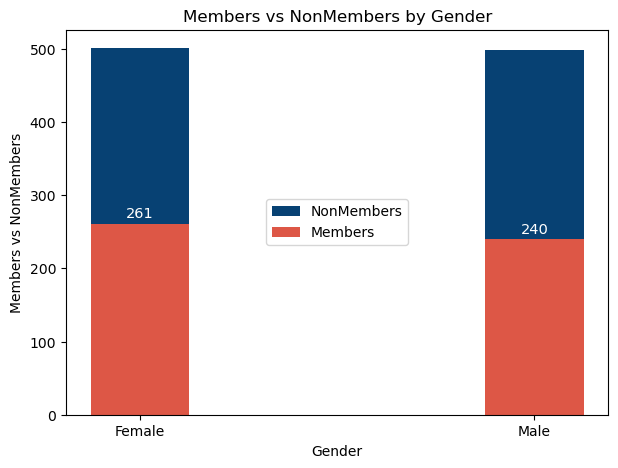

In [15]:
# Stacked Bar plot for the gender comparison
fig, ax1 = plt.subplots(figsize=(7,5))

# Number of Members (bottom part of the stacked bar chart)
members = ax1.bar(df_gender_comparison['gender'], df_gender_comparison['Members'],color='#DD5746', width=0.25, label='Members')

# Add text annotations 
for i in range(len(df_gender_comparison)):
  gender = df_gender_comparison['gender'][i]
  member = df_gender_comparison['Members'][i]
  ax1.text(gender, member + 8, member, ha="center", color='white', fontsize=10.5)

# Number of NonMembers
non_members = ax1.bar(df_gender_comparison['gender'], df_gender_comparison['NonMembers'],bottom=df_gender_comparison['Members'], color='#074173', width=0.25, label='Non Members')

# Set titles, labels and legends
ax1.set_title('Members vs NonMembers by Gender')
ax1.set_xlabel('Gender')
ax1.set_ylabel('Members vs NonMembers')
ax1.legend([non_members, members], ['NonMembers', 'Members'], loc='center')

plt.show()

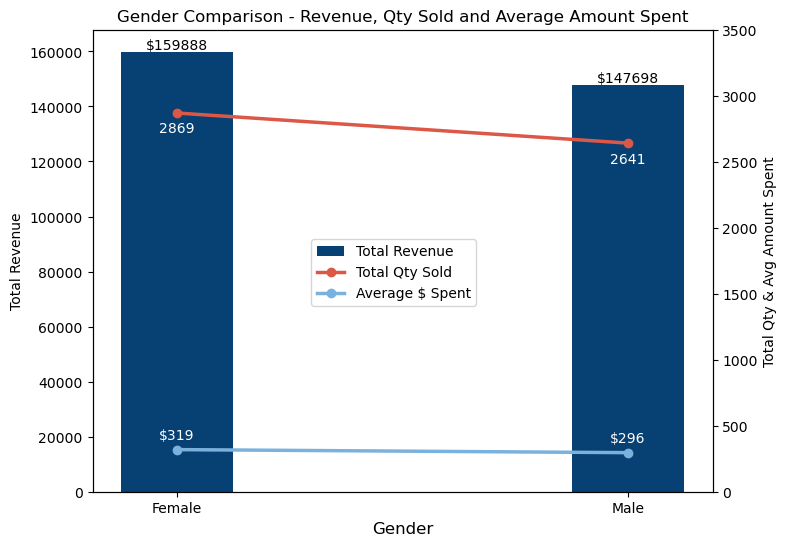

In [16]:
# Stacked Bar plot for the gender comparison
fig, ax1 = plt.subplots(figsize=(8, 6))

# Bar plot for the total revenue
ax1.bar(df_gender_comparison['gender'], df_gender_comparison['total_revenue'],
        color='#074173', width=0.25, label='Total Revenue')

# Add text annotations
for i in range(len(df_gender_comparison)):
    revenue = df_gender_comparison['total_revenue'][i]
    ax1.text(i, revenue + 1000, f'${int(revenue)}', ha="center", color='black')

# Create second axis in the figure
ax2 = ax1.twinx()

# Line plot for the total qty sold
ax2.plot(df_gender_comparison['gender'], df_gender_comparison['total_qty'],
         marker='o', color='#DD5746', linewidth=2.5, label='Total Qty Sold')

# Add text annotations over the line markers for total qty sold
for i in range(len(df_gender_comparison)):
    gender = df_gender_comparison['gender'][i]
    total_qty = df_gender_comparison['total_qty'][i]
    ax2.text(i, total_qty - 150, f'{total_qty}', ha="center", color='white')

# Line plot for the average amount spent
ax2.plot(df_gender_comparison['gender'], df_gender_comparison['avg_spent_per_customer'],
         marker='o', color='#7BB2DD', linewidth=2.5, label='Average $ Spent')

# Add text annotations over the line markers for average amount spent
for i in range(len(df_gender_comparison)):
    gender = df_gender_comparison['gender'][i]
    avg_spent = df_gender_comparison['avg_spent_per_customer'][i]
    ax2.text(i, avg_spent + 75, f'${avg_spent}', ha="center", color='white')

# Set titles, labels and legends
ax1.set_title('Gender Comparison - Revenue, Qty Sold and Average Amount Spent')
ax1.set_xlabel('Gender', fontsize=12)
ax1.set_ylabel('Total Revenue')
ax2.set_ylabel('Total Qty & Avg Amount Spent')
ax2.set_yticks(range(0,3501,500))

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2, loc='center', ncol=1)

plt.show()

#### *Key Insights*:
- **Female Customers Outperform Male Customers:**

    - Females generate approximately 160k in revenue, whereas males generate 148k.

    - On average, women spend $23 more per visit than men.

    - There are 9% more female members compared to male members.

- **Average Customer Satisfaction Rating:**

    - Both genders have an average rating of 7, suggesting room for improvement.

- **Shopping Time Preference:**

    - Men tend to visit the supermarket later in the day compared to women.

#### *Actionable Steps*:

- **Targeted Marketing Campaigns:**

    - Launch marketing campaigns aimed at male customers to increase their spending and encourage membership.
    
    - Focus these campaigns during the later hours of the day, when male customers are more likely to visit.

- **Enhance Sales Strategies for Female Customers:**

    - Continue enhancing strategies to boost sales among female customers, leveraging their potential for rapid revenue growth. 

- **Membership Program Optimization:**

    - Analyze the preferences of female and male members separately to come up with membership benefits more effectively.